In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf

/Users/paulag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
nino34 = np.array(nino34['nino34'].values)

In [3]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [4]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [5]:
clm = climatology(nino34)

In [6]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [7]:
anm = SST_anomaly(nino34, clm)
oni = ONI(anm)

# Data Preparation

In [8]:
T = 1      # prediction timeline
H = 48   # history used for prediction
include_month = 1           # 1 if we use the month as a feature, 0 otherwise
n_classes = 81               # number of classes (El Nino, El Nina, No Event)
threshold = 0.1         
signal = np.array(nino34[12 * 50:])   # data used for training/testing
length = signal.shape[0]    # number of data points

In [9]:
np.random.seed(0)

size = length - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H + include_month))
for i in range(size):
    if(include_month == False):
         data[i] = signal[i:(i + H)]
    else:
        data[i] = np.append(signal[i:(i + H)], (i + H + T) % 12)

labels = np.ndarray((size), dtype = int)
        
for i in range(size):
    labels[i] = np.trunc(oni[i + H + T] / threshold) + n_classes // 2
    labels[i] = max(labels[i], 0)
    labels[i] = min(labels[i], n_classes - 1) 

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[8 * split: 9 * split])
test_ind = np.array(shuffle[9 * split: size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])
        
mean = np.mean(train, axis = 0)
std = np.std(train, axis = 0)

train_n = np.divide(
        train - np.outer(np.ones(train.shape[0]), mean),
        np.outer(np.ones(train.shape[0]), std))

val_n = np.divide(
        val - np.outer(np.ones(val.shape[0]), mean),
        np.outer(np.ones(val.shape[0]), std))

test_n = np.divide(
        test - np.outer(np.ones(test.shape[0]), mean),
        np.outer(np.ones(test.shape[0]), std))
        
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    encoded_train_labels = tf.one_hot(train_labels, depth = n_classes).eval()
    encoded_val_labels = tf.one_hot(val_labels, depth = n_classes).eval()
    encoded_test_labels = tf.one_hot(test_labels, depth = n_classes).eval()

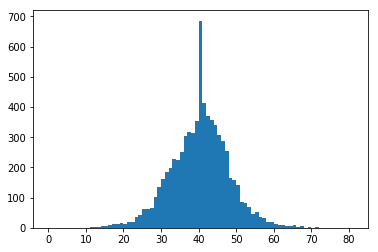

In [10]:
plt.hist(labels, n_classes, range = (0, n_classes));

# Training the Network

In [20]:
(d, N1, N2, N3) = (0.3, 768, 768, 384)
epochs = 40
        
acc = 0
loss = 0
        
model = tf.keras.models.Sequential([
              tf.keras.layers.Dense(N1, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N2, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N3, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
            ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_n, encoded_train_labels, epochs = epochs, verbose = 0)
(loss, acc) = model.evaluate(val_n, encoded_val_labels, verbose = 0)

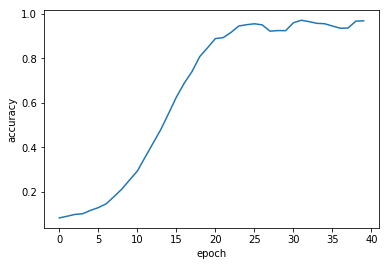

In [21]:
plt.plot(history.history['acc']);
plt.ylabel('accuracy');
plt.xlabel('epoch');

# Results (Validation)

In [22]:
print("Accuracy on Validation:", acc)

Accuracy on Validation: 0.15664335672671978


In [24]:
pred2 = pred - n_classes // 2
pred2 = np.maximum(pred2, -1)
pred2 = np.minimum(pred2, 1)

val_labels2 = val_labels - n_classes // 2
val_labels2 = np.maximum(val_labels2, -1)
val_labels2 = np.minimum(val_labels2, 1)

print(np.sum(pred2 == val_labels2) / val_labels.shape[0])

0.5986013986013986


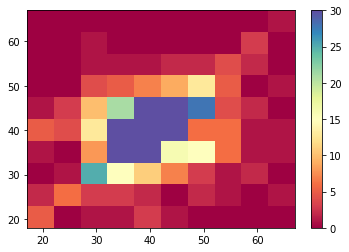

In [25]:
plt.hist2d(val_labels, pred, cmap = plt.cm.Spectral, vmax = 30);
plt.colorbar();

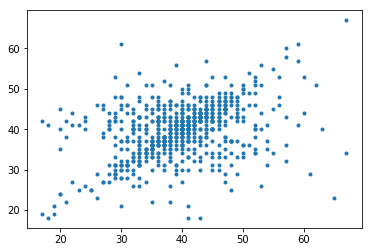

In [26]:
plt.plot(val_labels, pred, ".");

# Performance on Training Data

In [27]:
train_pred = model.predict_classes(train_n, verbose = 0)

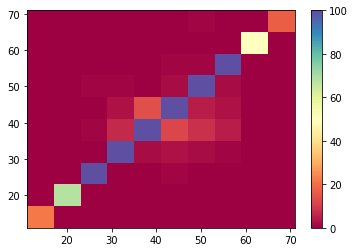

In [28]:
plt.hist2d(train_labels, train_pred, cmap = plt.cm.Spectral, vmax = 100);
plt.colorbar();

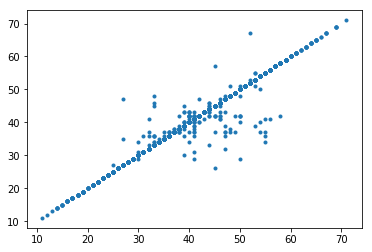

In [29]:
plt.plot(train_labels, train_pred, ".");

# Comparison with Support Vector Classifier

In [30]:
from sklearn import multiclass
from sklearn.svm import SVC

clf = multiclass.OneVsRestClassifier(SVC(kernel='rbf', random_state = 0))
clf.fit(train, train_labels)
acc_SVC = clf.score(val, val_labels)

print(np.around(acc_SVC * 100, decimals = 2), "%")

9.93 %
